In [1]:
# for cleaning up after tests
import os
dir = "../calibrate/"
for f in os.listdir(dir):
    if ".bin" in f:
        os.remove(os.path.join(dir, f))

In [1]:
from banners import *
# import csv_relations
import os
root = "../calibrate"
# get all dirs with data and order by date
'''
data_dirs = []
for dd in os.listdir(root):
    d = os.path.join(root, dd)
    print(d)
    if os.path.isdir(d):
        dir_files = Dir(d, dd)
        for f in os.listdir(d):
            if ".bag" in f:
                dir_files.bag = os.path.join(d, f)
            if ".csv" in f:
                dir_files.clicks = os.path.join(d, f)
        data_dirs.append(dir_files)
'''
data_dirs = []
dir_files = Dir(root, "test")
dir_files.bag = os.path.join(root, "rtk-co-locate.bag")
dir_files.clicks = os.path.join(root, "rtk-clicks.csv")
data_dirs.append(dir_files)

print(data_dirs)

TOPICS = ['/current_pose', '/cam0/nv12_decode_result', '/cam1/nv12_decode_result', '/therm/image_raw_throttle']

processed_data = []

# process each bag
for a in data_dirs:
    cc = CameraCombo(a)
    bag = rosbag.Bag(a.bag)
    for topic, msg, t in bag.read_messages(TOPICS):
        # print(topic)
        # stack 3 images together
        if topic == '/therm/image_raw_throttle':
            # print("thermal")
            cc.flir = msg
        if topic == '/cam1/nv12_decode_result':
            # print("rgb")
            cc.rgb = msg
        if topic == '/cam0/nv12_decode_result':
            # print("noir")
            cc.noir = msg
        if topic == "/current_pose":
            # print("stacking")
            cc.pose = msg.pose.pose
            cc.stack(t)
    processed_data.append(cc)
    cc.done()


    # get pose of stack
    # compute coords(xmin, ymin & xmax, ymax) of each stack
processed_data[0].parsed["xmax"]

[Dir(path='../calibrate', date='test', bag='../calibrate/rtk-co-locate.bag', clicks='../calibrate/rtk-clicks.csv')]


ValueError: operands could not be broadcast together with shapes (3,4) (3,) (3,4) 

In [3]:
import csv
import csv_relations
# import pymap3d as pm
import utm
proc_click = []

origin = None

# go over the CSVs
for a in data_dirs:
    C = csv_relations.CSVAugmented(a.path)
    with open(a.clicks) as clicks:
        reader = csv.reader(clicks)
        for line in reader:
            if origin == None:
                origin = [float(line[0]), float(line[1]), float(line[2])]
            # breakdown line
            u = utm.from_latlon(float(line[0]), float(line[1]))
            # u = pm.geodetic2ned(float(line[0]), float(line[1]), float(line[2]), origin[0], origin[1], origin[2])
            pt = [u[0], u[1]]
            # print(u)
            health = int(line[-1])
            
            C.jungler(pt, health, processed_data)

    C.done()
    proc_click.append(C)

1366    data/test_dir/stacked_1674593058.419452158.bin
1367    data/test_dir/stacked_1674593058.619295171.bin
1368    data/test_dir/stacked_1674593058.819392715.bin
1369     data/test_dir/stacked_1674593059.19749526.bin
2323    data/test_dir/stacked_1674593250.393662192.bin
2324    data/test_dir/stacked_1674593250.549231434.bin
2325    data/test_dir/stacked_1674593250.802911748.bin
2326    data/test_dir/stacked_1674593250.949266723.bin
2327    data/test_dir/stacked_1674593251.149145270.bin
2343    data/test_dir/stacked_1674593254.460468403.bin
2344    data/test_dir/stacked_1674593254.549322922.bin
2345    data/test_dir/stacked_1674593254.791617345.bin
2346    data/test_dir/stacked_1674593254.949156983.bin
2347    data/test_dir/stacked_1674593255.149159786.bin
2348    data/test_dir/stacked_1674593255.393803300.bin
2349    data/test_dir/stacked_1674593255.549133788.bin
2350    data/test_dir/stacked_1674593255.868490121.bin
2351    data/test_dir/stacked_1674593255.949396640.bin
2352    da

In [4]:
print(proc_click[0].related["x"].max(axis=0) - processed_data[0].parsed.pose.map(lambda x: x[0, 3]).max(axis=0))
print(proc_click[0].related["x"].min(axis=0) - processed_data[0].parsed.pose.map(lambda x: x[0, 3]).min(axis=0))
print(proc_click[0].related["y"].max(axis=0) - processed_data[0].parsed.pose.map(lambda x: x[1, 3]).max(axis=0))
print(proc_click[0].related["y"].min(axis=0) - processed_data[0].parsed.pose.map(lambda x: x[1, 3]).min(axis=0))

-1415811.865989245
369533.6477744338
-4728.257442008238
3119793.8430679953


584120.4616499385


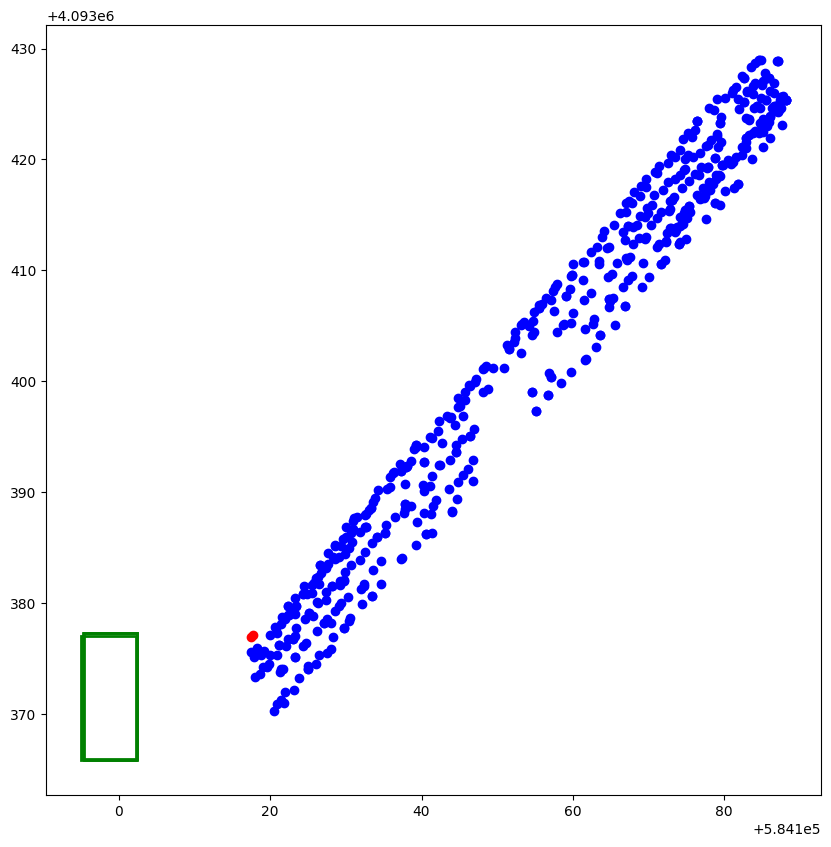

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


max_x = proc_click[0].related["x"].max(axis=0)
min_x = proc_click[0].related["x"].min(axis=0)
max_y = proc_click[0].related["y"].max(axis=0)
min_y = proc_click[0].related["y"].min(axis=0)

# plot click data
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(proc_click[0].related.x, proc_click[0].related.y, c='b')
p_x = processed_data[0].parsed.pose.map(lambda x: x[0, 3])
p_y = processed_data[0].parsed.pose.map(lambda x: x[1, 3])
zone = (p_x >= min_x) & (p_x <= max_x) & (p_y >= min_y) & (p_y <= max_y)
# vx_zone
vx_max = processed_data[0].parsed.xmax[zone]
vy_max = processed_data[0].parsed.ymax[zone]
vx_min = processed_data[0].parsed.xmin[zone]
vy_min = processed_data[0].parsed.ymin[zone]
pux = p_x[zone]
puy = p_y[zone]
start = 0
stop = 100
choice = 500
# print(pux)
ax.scatter(pux[0:2], puy[0:2], c="r")
print(vx_max.iloc[choice])
for choice in range(0, 3):
    h = vx_max.iloc[choice].item() - vx_min.iloc[choice].item()
    w = vy_max.iloc[choice].item() - vy_min.iloc[choice].item()
    rect = patches.Rectangle((vx_max.iloc[choice], vy_max.iloc[choice]), w, h, linewidth=2, edgecolor="g", facecolor='none')
    # plt.scatter(vx_max[start:stop], vy_max[start:stop], c="y")
    # plt.scatter(vx_min[start:stop], vy_min[start:stop], c="g")
    ax.add_patch(rect)
plt.show()

73.70572039985564 43.79454482207075
[5.87155751e+04 3.57045881e+04 1.00000000e+01]


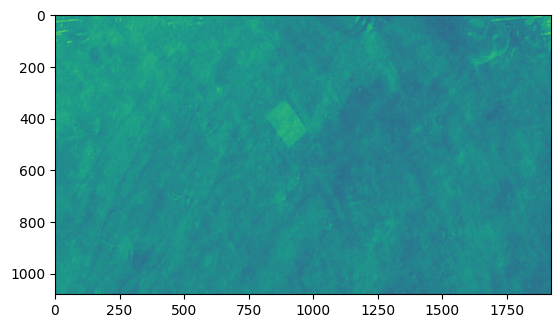

In [7]:
import matplotlib.patches as patches
from cv_bridge import CvBridge
from sensor_msgs.msg import Image

bridge = CvBridge()

# back projection time
def pretty_image(point, image, dataframe, img_type):
    file = open(image, 'rb')
    imgs = pickle.load(file)
    row = dataframe.loc[dataframe['save_loc'] == image]
    pose = row.pose.item()
    # subtract xmax and ymax from pt then use K to project back
    x = pt[0] - pose[0, 3]
    y = pt[1] - pose[1, 3]
    print(x, y)
    # print(type(list(imgs['rgb'].data)))
    fig, ax = plt.subplots()
    if img_type == 'flir':
        img = bridge.imgmsg_to_cv2(imgs[img_type])
        K = flir_K
    else:
        img = np.asarray(list(imgs[img_type].data)[:1080*1920]).reshape((1080, 1920))
        if img_type == 'noir':
            K = noir_K
        else:
            K = rbg_K

    l = np.array([x, y, 10]).T
    # print(l)
    xy = K@l
    print(xy)
    xy = xy / xy[2]
    x = xy[0]
    y = xy[1]
    # print(img.shape)
    ax.imshow(img)
    rect = patches.Rectangle((x, y), 40, 30, linewidth=2, edgecolor="r", facecolor='none')
    ax.add_patch(rect)

    plt.show()

def demo_wrapper(c, r, img_type):
    click_to_use = c
    relation_to_use = r
    pt = [proc_click[0].related.x[click_to_use], proc_click[0].related.y[click_to_use]]
    imgs = proc_click[0].related.relevant[0][relation_to_use]
    pretty_image(pt, imgs, processed_data[0].parsed, img_type)

demo_wrapper(0, 10, 'rgb')
# demo_wrapper(1, 10)

In [ ]:
for i in range(5):
    demo_wrapper(45, i, 'flir')